# 用概率定律处理不确定性  
重点：__即使 不确定发生什么也可以有明确的行动 可以确切知道最佳做法__  
在搜索问题中,建立了继续探索的前沿  
## 猪骰
- 2个玩家玩骰先到50分获胜 
- 可以连续掷骰(roll)累加到(pending)
- 可选择hold,pending记入分数，轮到对方
- 如果掷得1 pending分数记1记入分数,轮到对方

动作不确定(roll or hold)  
骰子掷出多少不确定(1到6)
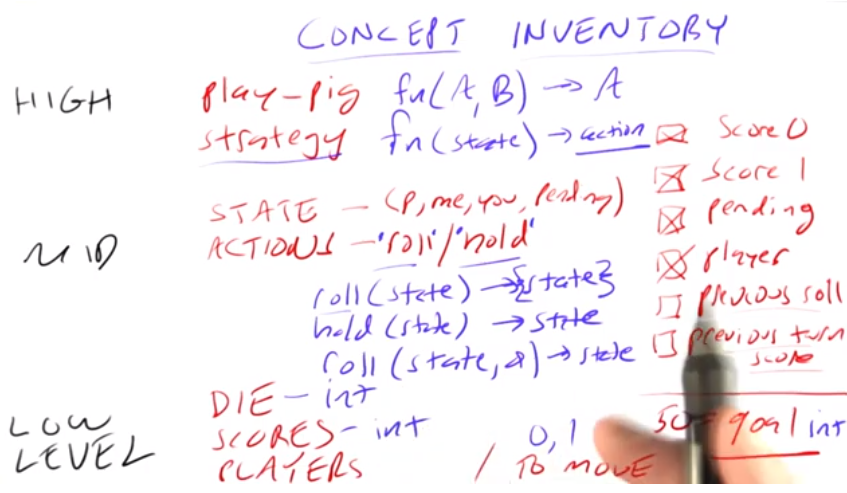

In [188]:
# actions
def hold(state):
    p,me,you,pending =state
    return (other[p],you,me+pending,0)

def roll(state,d):
    p,me,you,pending =state
    if d == 1:
        return hold((p,me,you,1))
    return (p,me,you,pending+d)

other = {1:0,0:1}

# strategies
import random
moves = ['roll','hold']
# 1
def clueless(state):
    return random.choice(moves)

# 2
goal = 50
# 一组策略函数 根据参数返回一个策略函数
def hold_at(x):
    def strategy(state):
        p,me,you,pending =state
        return 'hold' if (pending>=x or (pending + me >= goal))else 'roll'
            
    strategy.__name__ = f'hold_at({x})'
    return strategy



# 为了控制骰子方便测试 依赖(随机结果)注入(到参数)
def dierools():
    while True:yield random.randint(1,6)

# 主程序 AB是策略 也代表玩家
def play_pig(A,B,dierools=dierools()):
    state = (0,0,0,0)
    strategies = [A,B]
    while True:
        
        p,me,you,pending =state
        if me>=goal:
            return strategies[p]
        if you>=goal:
            return strategies[other[p]]
        match strategies[p](state):
            case 'hold':
                state = hold(state)
            case 'roll':
                state = roll(state,next(dierools))
            case _:
                # illegal action? You lose!
                return strategies[other[p]]
            
def test():
    A,B = hold_at(50),clueless
    rolls = iter([6]*9)
    assert play_pig(A,B,rolls) == A
    print('test pass')
test()

test pass


游戏已经实现
## 最优策略
即要击败对手 我方要最好 对方最坏情况   
而对方希望我方遇到最坏情况

向着目标搜索到目标
- 我方总是选择最有利的 
- 对方总是为我选择最差的 
- 骰子可以平均  
则 __整个路径是可以描述的__

经济学和博弈论中，状态的值被称为 __utility(效用)__：胜1,输0。  
__Quality__(质量）状态和动作的函数 返回效用  
可以这么说：在某状态下这个动作的质量 为我提供多少效用
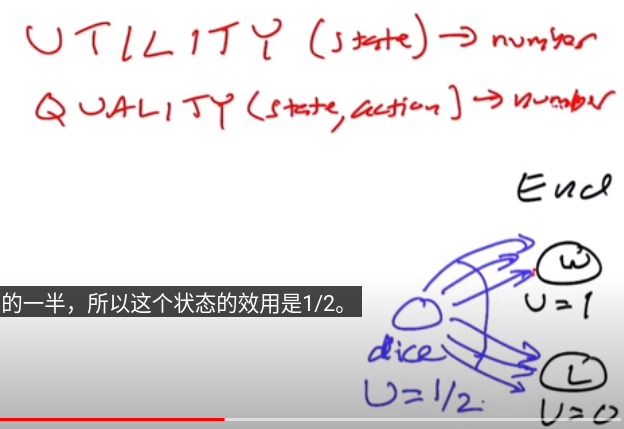

现在通过已知的描述 从最终状态倒退搜索 可以回溯到开始状态  
最优策略就是质量最高的路线

不确定情况下做决策且有对手 就是博弈论
### 先从没有对手的情况说
__不确定下的决策__

100万奖金 可以选择继续抛硬币 猜对300万 猜错归0 怎么玩  
编写模型 让决策理论做决定

In [140]:
million = 1e6
def Q(state,action,U):
    if action =='hold':
        return U(state+1*million)
    if action == 'gamble':
        return U(state+3*million)*.5 + U(state)*.5
    
def actions(state):return ('hold','gamble')
def indetity(x):return x # 效用函数最简单的选择 恒等
U = indetity

def best_action(state,actions,Q,U):
    def EU(action):return Q(state,action,U)
    return max(actions(state),key=EU)

best_action(100,actions,Q,indetity)

'gamble'

In [146]:
import math
best_action(million*1,actions,Q,math.log)

'hold'

## 回到猪骰
- 效用定义为获胜的概率

In [271]:
from functools import update_wrapper
def decorator(d):
    "Make function d a decorator: d wraps a function fn."
    def _d(fn):
        return update_wrapper(d(fn), fn)
    update_wrapper(_d, d)
    return _d

@decorator
def memo(f):
    """Decorator that caches the return value for each call to f(args).
    Then when called again with same args, we can just look it up."""
    cache = {}
    def _f(*args):
        try:
            return cache[args]
        except KeyError:
            cache[args] = result = f(*args)
            return result
        except TypeError:
            # some element of args can't be a dict key
            return f(args)
    _f.cache = cache
    return _f

In [273]:
def Q_pig(state,action,Pwin):
    if action == 'hold':
        # 我的效用 + 对手的效用 = 1
        return 1 - Pwin(hold(state))
    if action == 'roll':
        p_1 = 1 - Pwin(roll(state,1))
        p_23456 = sum(Pwin(roll(state,d))for d in [2,3,4,5,6])
        return (p_1+p_23456)/6
    
def pig_actions(state):
    *_,pending = state
    return ['roll','hold'] if pending else ['roll']

@memo
def Pwin(state):
    p,me,you,pending =state
    if me + pending>=goal:
        return 1
    if you >= goal:
        return 0
    return max(Q_pig(state,action,Pwin)
              for action in pig_actions(state))

Pwin((0,0,0,0))
len(Pwin.cache)

76875

In [261]:
def max_wins(state):
    return best_action(state,pig_actions,Q_pig,Pwin)

max_wins((0,0,0,0))

'roll'

## 高分取胜
- 修改效用

In [171]:
@memo
def U_win_diff(state):
    p,me,you,pending =state
    if me+pending>=goal or you>=goal:
        return (me + pending-you)
    else:
        return max( 
            Q_pig(state,action,win_diff)
            for action in pig_actions(state))

# 策略函数
def max_diff(state):
    return best_action(state,pig_actions,Q_pig,U_win_diff)

max_diff((0,0,0,0))

'roll'

In [190]:
# 游戏胜出者 不确定
play_pig(max_diff,hold_at(40))

<function __main__.max_diff(state)>

In [219]:
import itertools
goal = 40
states = [
    (0,me,you,pending)
    for me,you,pending in 
    itertools.product(range(41),range(41),range(41))
    if me+pending<=goal
]

from collections import defaultdict
r = defaultdict(int)
for s in states:r[max_wins(s),max_diff(s)]+=1
# 更激进的并不是max_diff策略 
# 比方远远落后的情况 为了盈选择roll,为了输的不难看选择hold
r

defaultdict(int,
            {('roll', 'roll'): 27672,
             ('hold', 'roll'): 579,
             ('hold', 'hold'): 2380,
             ('roll', 'hold'): 4670})

In [231]:
def story():
    r = defaultdict(lambda:[0,0])
    for s in states:
        w,d = max_wins(s),max_diff(s)
        if w!=d:
            *_,pending = s
            i = 0 if w=='roll' else 1
            r[pending][i]+=1
    for (delta,(wrollls,drolls)) in sorted(r.items()):
        print(f'{delta:0>2}: {wrollls:>3} {drolls:>3}')
story()

02:   0   1
03:   0   1
04:   0   1
05:   0   1
06:   0   1
07:   0   1
08:   0   1
09:   0   1
10:   0   1
11:  17   1
12:  21   1
13:  25   1
14:  41   1
15:  41   1
16:  55  20
17: 102  40
18: 130  59
19: 180  70
20: 235  70
21: 290  58
22: 349  26
23: 339  11
24: 323  16
25: 307  14
26: 282  18
27: 258  24
28: 236  27
29: 228  19
30: 202  21
31: 181  23
32: 158  25
33: 141  13
34: 132  10
35: 108   1
36:  78   0
37:  66   0
38:  56   0
39:  49   0
40:  40   0


> 上面的统计讲述了一个故事：这两个相似策略的差异，当少量待处理点数(<=10)...

https://www.youtube.com/watch?v=ytldCtQygRY&list=PLAwxTw4SYaPnJVtPvZZ5zXj_wRBjH0FxX

# 问题
> 2孩家庭里至少有一个男孩周二出生，生两个男孩的概率

In [260]:
sex = 'BG'
day = '1234567'

event2 = [ x for x in 
          map(''.join,itertools.product(sex,day,sex,day))
          if 'B2'in x]

( Fraction(len([x for x in event2 if x.count('B')==2]))
/ Fraction(len(event2)))

Fraction(13, 27)

# 练习
## 优化速度

In [279]:
goal = 40

def Pwin2(state):
    _, me, you, pending = state
    return Pwin3(me, you, pending)

@memo
def Pwin3(me, you, pending):
   ## your code here
    if me + pending >= goal:
        return 1
    elif you >= goal:
        return 0
    else:
        Proll = (1-Pwin3(you,me+1,0)+sum(Pwin3(me,you,pending+d) for d in (2,3,4,5,6)))/6
        return (Proll if not pending else max(Proll,1-Pwin3(you,me+pending,0)))

Pwin2((0,0,0,0))
len(Pwin3.cache)

39825

In [ ]:
# Doubling
def play_pig_d()

def actions_d():
    p, me, you, pending,double = state
    if (p == 0 and me == 1 )or (p==0 and you ==1):
        return ['accept','roll','hold']

def strategy_d(state):
    pass

def hold_20_d(state):
    p, me, you, pending,double = state
    return ('accept' if double == 'double' else
           'hold' if (pending >= 20 or me + pending >= goal)
           else 'roll')

def play_pig_d(A, B, dierolls=dierolls()):
    strategies = [A, B]
    state = (0, 0, 0, 0, 1)
    while True:
        (p, me, you, pending, double) = state
        if me >= goal:
            return strategies[p], double
        elif you >= goal:
            return strategies[other[p]], double
        else:
            action = strategies[p](state)
            state = do(action, state, dierolls)

## No more roll() and hold(); instead, do:

In [42]:
# 狐狸与鸡 

# 一副牌Fox or Hen 发牌放入院子
# 狐狸吃鸡 可选动作 收集院中小鸡
# 前提：知道总共多少牌 包括具体牌的数量

# top fn

import random
def fox_and_hens(strategy,foxes=7,hens=45):
    cards = 'F'*foxes+'H'*hens
    cards = ''.join(random.sample(cards,len(cards)))
    state = (score,yard,cards) = (0,0,cards)
    while cards:
        action = strategy(state)
        state = (score,yard,cards) = do(action,state)
    return score + yard

def do(action,state):
    (score,yard,cards) = state
    c,others = cards[0],cards[1:]
    match action,c:
        case 'wait','F':
            return (score,0,others)
        case 'wait','H':
            return (score,yard+1,others)
        case 'gather',_:
            return (score+yard,0,others)
        

def strategy_take_5(state):
    (score,yard,cards) = state
    if yard < 5:
        return 'wait'
    return 'gather'

def average_score(strategy,N=10000):
    return sum(fox_and_hens(strategy) for _ in range(N))/float(N)

def superior(A,B=strategy_take_5):
    print((a:=average_score(A)),b:=( average_score(B)))
    return a-b>1.5

def strategy_A(state):
    (score,yard,cards) = state
    if 'F' not in cards:
        return 'wait'
    if yard>=3:
        return 'gather'
    return 'wait'

# fox_and_hens(strategy_take_5)
superior(strategy_A)

32.3756 29.6315


True